Download dataset

In [ ]:
!unzip "drive/My Drive/bottels.zip"

Archive:  drive/My Drive/bottels.zip
   creating: test/
   creating: test/aluminium/
  inflating: test/aluminium/IMG_5129.jpg  
  inflating: test/aluminium/IMG_5135.jpg  
  inflating: test/aluminium/IMG_5146.jpg  
  inflating: test/aluminium/IMG_5147.jpg  
  inflating: test/aluminium/IMG_5150.jpg  
  inflating: test/aluminium/IMG_5152.jpg  
  inflating: test/aluminium/IMG_5154.jpg  
  inflating: test/aluminium/IMG_5155.jpg  
  inflating: test/aluminium/IMG_5162.jpg  
  inflating: test/aluminium/IMG_5171.jpg  
  inflating: test/aluminium/IMG_5173.jpg  
  inflating: test/aluminium/IMG_5175.jpg  
  inflating: test/aluminium/IMG_5177.jpg  
  inflating: test/aluminium/IMG_5180.jpg  
  inflating: test/aluminium/IMG_5198.jpg  
  inflating: test/aluminium/IMG_5211.jpg  
  inflating: test/aluminium/IMG_5212.jpg  
  inflating: test/aluminium/IMG_5215.jpg  
  inflating: test/aluminium/IMG_5216.jpg  
  inflating: test/aluminium/IMG_5224.jpg  
  inflating: test/aluminium/IMG_5225.jpg  
  inflating:

Import libraries

In [ ]:
import numpy as np 
import pandas as pd 

import os
import random as rdm
import time
from shutil import copyfile
from typing import Iterable
from dataclasses import dataclass

import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim import lr_scheduler

from torch.utils.tensorboard import SummaryWriter

Resize images with the smallest side of 400 pixels

In [ ]:
for i in ["train", "validation", "test"]:
  for j in ['aluminium', 'glass', 'plastic']:
    for  name in os.listdir(os.path.join(i, j)):
      im = cv2.imread(os.path.join(i, j, name))
      h, w = im.shape[:2]
      f = max([400/h, 400/w])
      new_im = cv2.resize(im, None, fx=f, fy=f)
      cv2.imwrite(os.path.join(i, j, name), new_im)

In [ ]:
random_seed = 16

Plot some examples

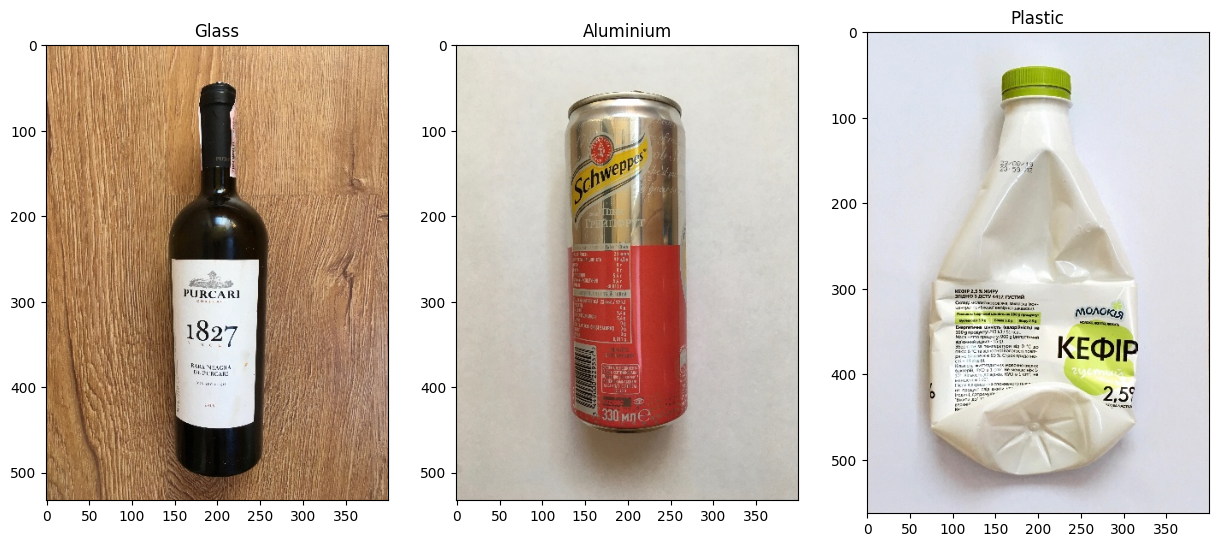

In [ ]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (15, 9)
fig = plt.figure()
plt.subplot(1,3, 1)
img_g = cv2.imread("train/glass/IMG_2767.jpeg")
plt.imshow(img_g[:,:,::-1])
plt.gca().set_title('Glass')
plt.subplot(1,3, 2)
img_a = cv2.imread("train/aluminium/IMG_1764.jpeg")
plt.imshow(img_a[:,:,::-1])
plt.gca().set_title('Aluminium')
plt.subplot(1,3, 3)
img_p = cv2.imread("train/plastic/IMG_1857.jpeg")
plt.imshow(img_p[:,:,::-1])
plt.gca().set_title('Plastic')
plt.show()

Amount of data

In [ ]:
for i in ["train", "validation", "test"]:
  print("\n" + i)
  for j in ['aluminium', 'glass', 'plastic']:
    print (j+": " + str(len(os.listdir(os.path.join(i, j)))) + " images")


train
aluminium:642 images
glass:369 images
plastic:885 images

validation
aluminium:160 images
glass:92 images
plastic:221 images

test
aluminium:100 images
glass:100 images
plastic:100 images


## Training

Function to get dataloaders in apropriate type for training

In [ ]:
def get_data(batch_size, image_root, num_workers=4, data_augmentation=True):
       
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    
    common_transforms = transforms.Compose([
                        transforms.Resize(400),
                        transforms.CenterCrop(350),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])
        
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = transforms.Compose([transforms.Resize(400), # to 400x400
                           transforms.RandomVerticalFlip(),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomAffine(90, shear=45), # rotation up to 90 degrees and shear up to 45 degrees
                           transforms.ColorJitter(0.2, 0.2 ,0.2, 0.2), # brightness, contrast, saturation, hue
        
                           transforms.RandomCrop(350),
                           transforms.ToTensor(),
                           transforms.Normalize(mean, std)
                           ])
    # else do common transforms
    else:
        train_transforms = common_transforms
        
    
    # train dataloader
    train_data_path = os.path.join(image_root, 'train')
    train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              num_workers=num_workers,
                                              shuffle=True)
    
    
    # validation dataloader
    valid_data_path = os.path.join(image_root, 'validation')
    valid_dataset = datasets.ImageFolder(valid_data_path, transform=common_transforms)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                              batch_size=batch_size,
                                              num_workers=num_workers,
                                              shuffle=False)

    
    return train_loader, valid_loader

In [ ]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 25 # number of images in one batch
    epochs_count: int = 75 # number of epochs
    init_learning_rate: float = 0.001  # initial learning rate for lr scheduler
    decay_rate: float = 0.1 # decay rate for scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    image_root: str = ""  
    num_workers: int = 4  
    device: str = 'cuda'

In [ ]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 16  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

Class for metric

In [ ]:
class Accuracy():
    def __init__(self):
        self.acc = np.array([])

    def reset(self):
        self.acc = np.array([])

    def update_value(self, output, target, per_batch=True):
        """Computes the precision@k for the specified values of k"""
        with torch.no_grad():
            prob = F.softmax(output, dim=1)    
            pred = prob.data.max(dim=1)[1] 
            correct = pred.cpu().eq(target.cpu()).sum()
            if per_batch:
                ac = float(correct) / float(len(target))
                self.acc = np.append(self.acc, [ac])
            else:
                self.acc = np.append(self.acc, [correct])


    def get_metric_value(self, per_batch=True):
        if per_batch:
            return self.acc.mean()
        return self.acc.sum()

Function for one iteration of training/validation process

In [ ]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer, metric: Accuracy,
    train_loader: torch.utils.data.DataLoader, class_weigths, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    metric.reset()
        
    for batch_idx, (data, target) in enumerate(train_loader):
        # clone target
        indx_target = target.clone()
        # send data to device (its is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target, weight=class_weigths)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        metric.update_value(output, target)
        
            
    epoch_loss = batch_loss.mean()
    epoch_acc = metric.get_metric_value()
    return epoch_loss, epoch_acc
    
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader, class_weigths, metric: Accuracy
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    metric.reset()
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target, weight=class_weigths).item()
        
        # Score to probability using softmax
        metric.update_value(output, target, False)

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = metric.get_metric_value(False)
    
    return test_loss, accuracy/len(test_loader.dataset)

Function for model definition

In [ ]:
def get_model(n_l = 10, num_class=3):
    model = models.resnet18(pretrained=True)
    
    all_l = 0
    for name, child in model.named_children():
        #for name2, params in child.named_parameters():
          all_l += 1
    ct=0
    for name, child in model.named_children():
        ct += 1
        for name2, params in child.named_parameters():  
          #ct += 1
          if ct < all_l - n_l:  
                params.requires_grad = False
            
    last_layer_in = model.fc.in_features
    first_out_n = int((last_layer_in*num_class)**0.5)#int(((last_layer_in**2)*num_class)**0.333)#
    #second_out_n = int((first_out_n*num_class)**0.5)
    last_layers = nn.Sequential(
            nn.Linear(last_layer_in, out_features=first_out_n*3),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        
            #nn.Linear(in_features=first_out_n, out_features=second_out_n), 
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
            
            nn.Linear(in_features=first_out_n*3, out_features=num_class)
        )

    model.fc = last_layers#nn.Secnn.Linear(last_layer_in, num_class)
    
    return model

Function for one batch prediction

In [ ]:
def prediction(model, device, batch_input, max_prob=True):
    """
    get prediction for batch inputs
    """
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)
    
    if max_prob:
        # get the max probability
        pred_prob = prob.data.max(dim=1)[0]
    else:
        pred_prob = prob.data
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [ ]:
def get_target_and_prob(model, dataloader, device):
    """
    get targets and prediction probabilities
    """
    
    pred_prob = []
    targets = []
    
    for _, (data, target) in enumerate(dataloader):
        
        _, prob = prediction(model, device, data, max_prob=False)
        
        pred_prob.append(prob)
        
        target = target.numpy()
        targets.append(target)
        
    targets = np.concatenate(targets)
    targets = targets.astype(int)
    pred_prob = np.concatenate(pred_prob, axis=0)
    
    return targets, pred_prob

Function for optimizer and sheduler definition

In [ ]:
def get_optimizer_and_scheduler(model):
    train_config = TrainingConfiguration()

    init_learning_rate = train_config.init_learning_rate

    # optimizer
    optimizer = optim.Adam(
        model.parameters(),
        lr = init_learning_rate,
    )

    decay_rate = train_config.decay_rate

    lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

    # Scheduler
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)
    
    return optimizer, scheduler

In [ ]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

Main function for training process

In [ ]:
def main(model, optimizer, metric, weigths, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=False):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 6
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        image_root=training_configuration.image_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)
    weigths.to(training_configuration.device)
    
    
    # add network graph with inputs info
    images, labels = next(iter(test_loader))
    images = images.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, metric, train_loader,weigths, epoch)
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])
        

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print("Epoch: {}/{}, loss: {}, acc: {}, time: {}".format(epoch+1,training_configuration.epochs_count, 
                                                                 train_loss, train_acc, speed_epoch))
      
        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader,weigths, metric)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            print("Validation, Epoch: {}, loss: {}, acc: {}".format(epoch+1, current_loss, current_accuracy))
            if current_loss < best_loss:
                best_loss = current_loss
                torch.save(model.state_dict(), "drive/My Drive/best_model.pt")
        
        # scheduler step/ update learning rate
        if scheduler is not None:
            scheduler.step()                
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
  
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [ ]:
model = get_model(2) # get model
optimizer, scheduler = get_optimizer_and_scheduler(model) # get optimizer and scheduler
metric = Accuracy() # get metric
class_weights = torch.tensor([0.57476635514018691588785046728972, 1.0, 0.41694915254237288135593220338983]) # weigths for loss function

model, train_loss_exp, train_acc_exp, val_loss_exp, val_acc_exp = main(model, 
                                                                      optimizer, 
                                                                      metric,
                                                                      class_weights.to("cuda"),
                                                                      scheduler,
                                                                      data_augmentation=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch: 1/75, loss: 0.43391379674798564, acc: 0.8182205513784462, time: 48.845600605010986
Validation, Epoch: 1, loss: 0.18770880977574148, acc: 0.9302325581395349
Epoch: 2/75, loss: 0.2924519175369489, acc: 0.8901253132832081, time: 54.94125759601593
Validation, Epoch: 2, loss: 0.38327278501865775, acc: 0.8816067653276956
Epoch: 3/75, loss: 0.20980992366706855, acc: 0.9244360902255643, time: 54.64928070704142
Validation, Epoch: 3, loss: 0.13337892271872415, acc: 0.9513742071881607
Epoch: 4/75, loss: 0.1747705340385437, acc: 0.9328571428571428, time: 54.67748820781708
Validation, Epoch: 4, loss: 0.21259564983519771, acc: 0.9534883720930233
Epoch: 5/75, loss: 0.17859337297513297, acc: 0.9394736842105263, time: 54.55831956863403
Validation, Epoch: 5, loss: 0.0934402217081745, acc: 0.9619450317124736
Epoch: 6/75, loss: 0.13577490530319905, acc: 0.9520050125313282, time: 54.62100485960642
Validation, Epoch: 6, loss: 0.09765535553091659, acc: 0.9661733615221987
Epoch: 7/75, loss: 0.11854046

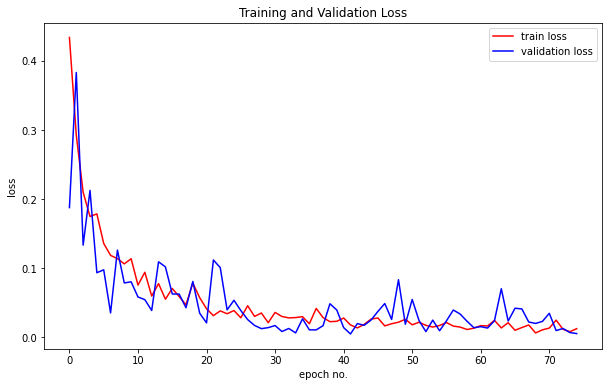

In [ ]:
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(train_loss_exp))

plt.figure
plt.plot(x, train_loss_exp, color='r', label="train loss")
plt.plot(x, val_loss_exp, color='b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

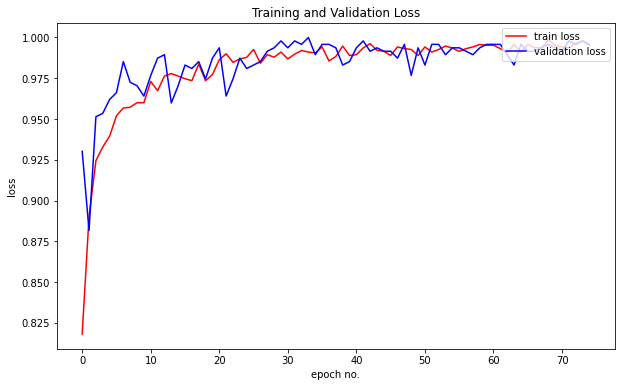

In [ ]:
# Plot acc
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(train_acc_exp))

plt.figure
plt.plot(x, train_acc_exp, color='r', label="train loss")
plt.plot(x, val_acc_exp, color='b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#dataset.class_to_idx {'aluminium': 0, 'glass': 1, 'plastic': 2}

## Testing

In [ ]:
model = get_model(2)
model.load_state_dict(torch.load("drive/My Drive/best_model.pt", map_location=torch.device('cpu')))
model.to("cpu")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

common_transforms = transforms.Compose([
                    transforms.Resize(400),
                    transforms.CenterCrop(350),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                    ]) 

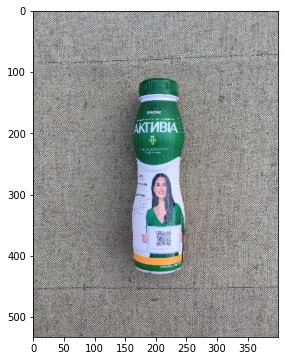

class [1] confidance [0.62125814] time: 0.4477989673614502


In [ ]:
times = []
correct = 0
all = 0
for i in ['aluminium', 'glass', 'plastic']:
  for name in os.listdir(os.path.join("test", i)):
    tim = time.time()
    im = Image.open(os.path.join("test", i,name))
    #width, height = im.size 
    #f = max([400/height, 400/width])
    #res_im  = im.resize((int(width*f), int(height*f))) 
    data = common_transforms(im).float()
    pred = prediction(model, "cpu", data.unsqueeze(0))
    times.append(time.time()-tim)
    all += 1
    if ['aluminium', 'glass', 'plastic'][pred[0][0]] != i:
      plt.imshow(im)
      plt.show()
      print("class",pred[0], "confidance", pred[1], "time:", time.time()-tim)
    else:
      correct+=1


In [ ]:
all, correct, all-correct, correct/all

(300, 299, 1, 0.9966666666666667)

In [ ]:
np.array(times).min(),np.array(times).mean(),np.array(times).max() 

(0.19028306007385254, 0.19818134943644206, 0.32821226119995117)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import itertools

def calculate_and_plot_confusion_matrix(model,data_root, classes=['aluminium', 'glass', 'plastic'], title='Confusion matrix', cmap=plt.cm.viridis):
    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
    test_dataset = datasets.ImageFolder(root=data_root, transform=common_transforms)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=15, num_workers=num_workers, shuffle=False)
    
    model.eval()
    targets = []
    preds = []
    for data, target in test_loader:
        indx_target = target.clone()
        target = target.to(device)
        preds += [p.tolist() for p in prediction(model, device, data)[0]]
        targets += [t.tolist() for t in target]
    
    cm = confusion_matrix(targets, preds)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

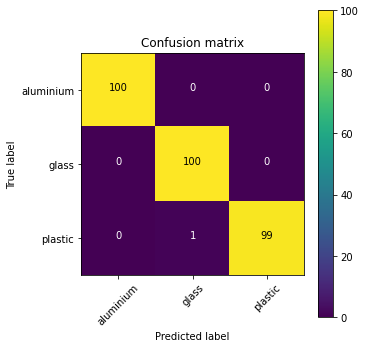

In [ ]:
plt.figure(figsize=(5,5))
calculate_and_plot_confusion_matrix(model, "test")

In [ ]:
def get_sample_prediction(model, data_root, mean, std, transform):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=transform)
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=transforms.Compose([transforms.Resize(350), transforms.ToTensor()]))
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.4}), T:{2}'.format(test_dataset.classes[cls[i]][:2], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]][:2]))
    fig.savefig('sample_prediction.png')
    plt.show()
    
    return

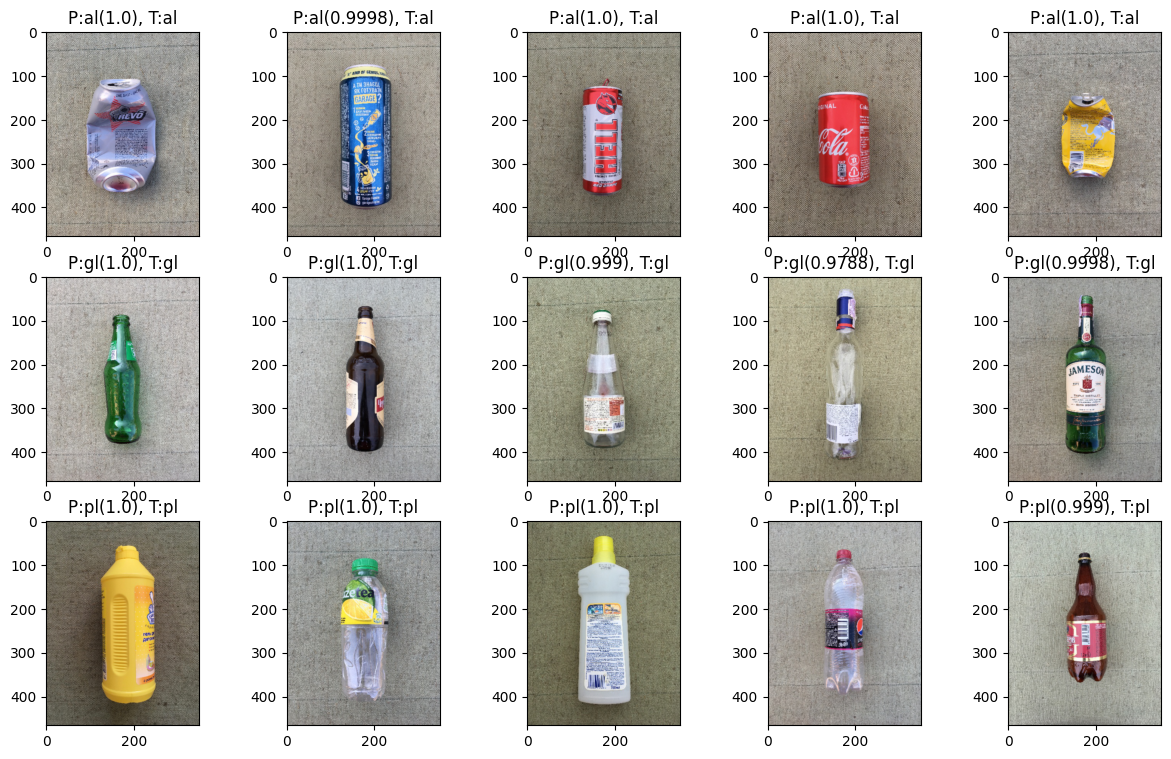

In [ ]:
get_sample_prediction(model, "test", mean, std, common_transforms)